In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/av-janatahack-machine-learning-in-agriculture/train.csv
/kaggle/input/av-janatahack-machine-learning-in-agriculture/test.csv
/kaggle/input/av-janatahack-machine-learning-in-agriculture/sample_submission.csv


In [33]:
train= pd.read_csv("/kaggle/input/av-janatahack-machine-learning-in-agriculture/train.csv")
test= pd.read_csv("/kaggle/input/av-janatahack-machine-learning-in-agriculture/test.csv")
submission= pd.read_csv("/kaggle/input/av-janatahack-machine-learning-in-agriculture/sample_submission.csv")

In [3]:
train.head()

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
0,F00000001,188,1,0,1,0,0.0,0,1,0
1,F00000003,209,1,0,1,0,0.0,0,2,1
2,F00000004,257,1,0,1,0,0.0,0,2,1
3,F00000005,257,1,1,1,0,0.0,0,2,1
4,F00000006,342,1,0,1,0,0.0,0,2,1


In [4]:
test.head(5)

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season
0,F00000002,188,1,1,1,0,NaN,0,2
1,F00000007,410,1,1,1,0,0.0,0,2
2,F00000011,626,1,0,1,0,0.0,0,2
3,F00000013,731,1,0,1,0,0.0,0,2
4,F00000014,789,0,0,1,0,0.0,0,1


In [34]:
train.isnull().sum()

ID                            0
Estimated_Insects_Count       0
Crop_Type                     0
Soil_Type                     0
Pesticide_Use_Category        0
Number_Doses_Week             0
Number_Weeks_Used          9000
Number_Weeks_Quit             0
Season                        0
Crop_Damage                   0
dtype: int64

In [35]:
train['Number_Weeks_Used'].fillna(train['Number_Weeks_Used'].mean(), inplace= True)

In [36]:
test.isnull().sum()

ID                            0
Estimated_Insects_Count       0
Crop_Type                     0
Soil_Type                     0
Pesticide_Use_Category        0
Number_Doses_Week             0
Number_Weeks_Used          5893
Number_Weeks_Quit             0
Season                        0
dtype: int64

In [37]:
test['Number_Weeks_Used'].fillna(test['Number_Weeks_Used'].mean(), inplace= True)

In [9]:
train.dtypes, test.dtypes

(ID                          object
 Estimated_Insects_Count      int64
 Crop_Type                    int64
 Soil_Type                    int64
 Pesticide_Use_Category       int64
 Number_Doses_Week            int64
 Number_Weeks_Used          float64
 Number_Weeks_Quit            int64
 Season                       int64
 Crop_Damage                  int64
 dtype: object,
 ID                          object
 Estimated_Insects_Count      int64
 Crop_Type                    int64
 Soil_Type                    int64
 Pesticide_Use_Category       int64
 Number_Doses_Week            int64
 Number_Weeks_Used          float64
 Number_Weeks_Quit            int64
 Season                       int64
 dtype: object)

# Basic EDA

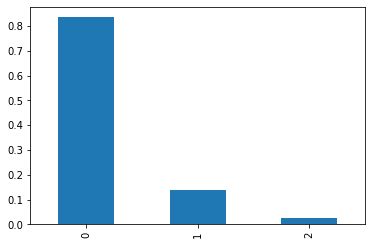

In [10]:
#target variable
train['Crop_Damage'].value_counts(normalize= True).plot(kind= 'bar')

morethan 75% are not defaulters from train

In [38]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV

In [39]:
X= train.drop(columns= ["Crop_Damage", "ID"])
y= train['Crop_Damage']
test_o= test
test= test.drop(columns= ["ID"])

In [14]:
#feature scaling
from sklearn.preprocessing import LabelEncoder, StandardScaler

le = LabelEncoder()
sc = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)



In [15]:
#logistic regression


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


log_reg = LogisticRegression()
lg= log_reg.fit(X_train, y_train)
y_pred = lg.predict(X_test)

acc= accuracy_score(y_test, y_pred)
print("Accuracy: {:.2%}".format(acc))

Accuracy: 83.33%


In [16]:
predicted= lg.predict(test)
sub= pd.DataFrame()
sub['ID']= test_o['ID']
sub['Crop_Damage']= predicted
sub.to_csv("lg.csv", index= False)

In [17]:
sub.describe()

,Crop_Damage
count,59310.000000
mean,1.000944
std,0.030713
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,2.000000


In [59]:
# split train into 5 folds and apply random forest and check accuracy of each fold

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold,KFold
from lightgbm                         import LGBMClassifier
from catboost                         import CatBoostClassifier

x = X
y = y
#rf = RandomForestClassifier(n_estimators=50)

#categorical_features = ["Gender", "Ever_Married" ,"Graduated" ,"Profession" ,"Spending_Score" ,"Var_1" ]

#rf_1 = LGBMClassifier(learning_rate=0.1,
#                     boosting_type='gbdt', max_depth=4,  objective='multiclass', 
#                     random_state=100,  
#                   n_estimators=1000 ,reg_alpha=0, reg_lambda=1, n_jobs=-1)

#rf_2 = CatBoostClassifier(learning_rate=0.15, n_estimators=1000, subsample=0.085, max_depth=5, 
#                                                                  verbose=400,
#                                                                 bootstrap_type="Bernoulli",
#                                                                  class_weights=[1, 1, 1, 1],
#                                                                  loss_function='MultiClass')

#rf = VotingClassifier(estimators=[ 
#                                                                      ('CatBoost_Best', rf_1),
#                                                                      ('LightGBM_Best', rf_2),], 
#                                                                      voting='soft',weights=[5,5.2])

rf = LGBMClassifier(learning_rate=0.02,
                    boosting_type='gbdt', max_depth=4,  objective='multiclass', 
                    random_state=100,  
                  n_estimators=1000 ,reg_alpha=0, reg_lambda=1, n_jobs=-1)

# # all blank values replace with mode 
# for column in df.columns:
#     df[column].fillna(df[column].mode()[0], inplace=True)

kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=10)
acc = []

for fold,(t_id,v_id) in enumerate(kf.split(x,y)):
    tx = x.iloc[t_id]; ty = y.iloc[t_id]
    vx = x.iloc[v_id]; vy = y.iloc[v_id]
    rf.fit(tx,ty 
#           categorical_feature = categorical_features
#            cat_features = categorical_features
          )
           
    val_y = rf.predict(vx)
    acc_score = accuracy_score(vy,val_y)
    acc.append(acc_score)
    print(f"fold {fold} accuracy {acc_score}")

print(f"Mean accuracy score {np.mean(acc_score)}")

CatBoostError: catboost/libs/data/util.h:33: class weights size data size (4) is not equal to class count (3)

In [45]:
pred= rf.predict(test)
sub= pd.DataFrame()
sub['ID']= test_o['ID']
sub['Crop_Damage']= pred
sub.to_csv("lgbm.csv", index= False)

In [46]:
sub.describe()

,Crop_Damage
count,59310.000000
mean,0.044276
std,0.205791
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,2.000000
